# Install Ultralytics:
To run Yolo's Model on the Data you should have to install the Ultralytics package if Using 
virtual GPU like in Colab or kaggle just simply run the command.

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 878.7/878.7 kB 15.2 MB/s eta 0:00:00a 0:00:01


# Import Necessary Packages:

In [2]:
import yaml
import os
import hashlib
import shutil
import json
import torch
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Issue with Data:
* While fitching classes it says it contain 36 classes from 0 to 35
* Some labeling are incorrect
* Out of 36 there is 11 classes which are in include in labels but have no correspond images

## **PREPROCESS DATA:**

*  **Explanation:** As we have issue of the classes in out dataset like having the labels of some classes but its corresponding images are not available in train/Val Dataset. According to index form out of 36 classes Data didn't include These Classes `[4,5,7,10,11,18,25,28,29,33,34]` , to resolve this issue we have to remove this labels and clean our Data so that it can run successfully by yolov5m Model. For acheiving this we did some procedure which are as follows;

## PROCEDURE:
1. **Filter Out Missing Classes:** Copy only the images and labels that do not contain the missing classes`[4, 5, 7, 10, 11, 18, 25, 28, 29, 33, 34]` to a new output directory.
2. **Re-map Class Indices:** Update the class indices in the label files to remove the gaps created by the missing classes. For example, if Class 4 is missing, Class 6 will become Class 4, and so on.
3. The `process_data` function takes some inputs and it filter out labels with missing  classes and copy the clean data from directory valid and train to the out directory as i did this code on `kaggle Notebook` so we can't do changes to input directory that's why i have to copy it to output kaggle directory. I already mentioned in the code if you are using another enviornment then just filter the data and use only clean data.


In [5]:
def process_data(input_labels_dir, input_images_dir, output_labels_dir, output_images_dir, missing_classes, remap_indices):
    """Process data by filtering out labels with missing classes and copying valid images and labels."""
    # Ensure output directories exist
    os.makedirs(output_labels_dir, exist_ok=True)
    os.makedirs(output_images_dir, exist_ok=True)

    # Process label files, remapping classes and copying valid files
    for label_file in os.listdir(input_labels_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(input_labels_dir, label_file)
            new_lines = []
            valid_file = True

            # Read the label file and remap classes
            with open(label_path, 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])

                    # Skip label files with missing classes
                    if class_id in missing_classes:
                        valid_file = False
                        break

                    # Remap the class ID to the new index
                    remapped_class_id = remap_indices[class_id]
                    new_line = line.replace(str(class_id), str(remapped_class_id), 1)
                    new_lines.append(new_line)

            # If the label file is valid, copy it and the corresponding image
            if valid_file:
                # Save the updated label file
                new_label_path = os.path.join(output_labels_dir, label_file)
                with open(new_label_path, 'w') as file:
                    file.writelines(new_lines)

                # Copy the corresponding image
                image_file = label_file.replace('.txt', '.jpg')  # Adjust if images have different extensions
                image_path = os.path.join(input_images_dir, image_file)
                if os.path.exists(image_path):
                    shutil.copy(image_path, output_images_dir)
                    print(f"Copied image and label: {image_file}")


### Initializing Paths:
You can adjust it according to your own paths to Data Set.


In [6]:
# Define directories for train and validation sets
train_labels_dir = '/kaggle/input/object-detection-of-26-objects/dataset_26/train/labels'  
train_images_dir = '/kaggle/input/object-detection-of-26-objects/dataset_26/train/images'
output_train_labels_dir = '/kaggle/working/filtered_dataset/train/labels'
output_train_images_dir = '/kaggle/working/filtered_dataset/train/images'

valid_labels_dir = '/kaggle/input/object-detection-of-26-objects/dataset_26/valid/labels'  
valid_images_dir = '/kaggle/input/object-detection-of-26-objects/dataset_26/valid/images'
output_valid_labels_dir = '/kaggle/working/filtered_dataset/valid/labels'
output_valid_images_dir = '/kaggle/working/filtered_dataset/valid/images'

### Remaping Classes:

In [7]:
# Define classes to exclude and initialize remapped classes
missing_classes = [4, 5, 7, 10, 11, 18, 25, 28, 29, 33, 34]
all_classes = list(range(36))  # Full range of classes from 0 to 35
present_classes = [cls for cls in all_classes if cls not in missing_classes]  # Classes that are present

# Define the final class names after excluding the missing classes
class_name_mapping = {
    0: 'Bus', 1: 'Bushes', 2: 'Person face', 3: 'Truck', 6: 'bicycle', 8: 'branch',
    9: 'Car', 12: 'Crosswalk', 13: 'Door', 14: 'Elevator', 15: 'fire hydrant',
    16: 'Green Light', 17: 'Gun', 19: 'Motorcycle', 20: 'person', 21: 'pothole',
    22: 'Rat', 23: 'Red Light', 24: 'scooter', 26: 'Stairs', 27: 'Stop Sign',
    30: 'Traffic cone', 31: 'Train', 32: 'Tree', 35: 'Yellow light'
}

### Calling Proccess Function:

In [8]:
# Create a remapped index for each present class
remap_indices = {old_index: new_index for new_index, old_index in enumerate(present_classes)}

# Process the train and validation datasets
process_data(train_labels_dir, train_images_dir, output_train_labels_dir, output_train_images_dir, missing_classes, remap_indices)
process_data(valid_labels_dir, valid_images_dir, output_valid_labels_dir, output_valid_images_dir, missing_classes, remap_indices)


Copied image and label: dcb16b131ab785ab_jpg.rf.e53c3e69781c896c54f1871e9b5dd3d3.jpg
Copied image and label: XeDap-198-_jpg.rf.6688de5e3b385eea9f66b3f59e2a5fbb.jpg
Copied image and label: Istanbul-4K-Driving-Downtown-Turkey_Part33_mp4-18_jpg.rf.c3e7768ec814acd33a272c2ca6108c40.jpg
Copied image and label: armas-488-_jpg.rf.829b38b7d3105cdde2ec86d42983e3d9.jpg
Copied image and label: 16912532177522988_10_jpg.rf.3f0fdf1106a9401553f7008bc1625556.jpg
Copied image and label: traffic-light-53-_jpg.rf.3c4192efb18b01406ef4d503b172196f.jpg
Copied image and label: traffic-light-65-_jpg.rf.de6471aeb686b5d81cd31adc0cdc9c74.jpg
Copied image and label: broto_445_png_jpg.rf.26af58c184236d3f7234ef59f33c9bf0.jpg
Copied image and label: traffic-light-50-_jpg.rf.baf6330d06b994f2e5de10084735b282.jpg
Copied image and label: 325946511_587456049844102_4538640819292170444_n_jpg.rf.97af7833db2dd634ce22ece009916aff.jpg
Copied image and label: 135_png_jpg.rf.7d9f234e34494fa612ce42ad06ddaf89.jpg
Copied image and l

In [9]:
# Generate class names for the `dataset.yaml` file in the correct order
class_names_ordered = [class_name_mapping[cls] for cls in present_classes]
class_names_ordered

['Bus',
 'Bushes',
 'Person face',
 'Truck',
 'bicycle',
 'branch',
 'Car',
 'Crosswalk',
 'Door',
 'Elevator',
 'fire hydrant',
 'Green Light',
 'Gun',
 'Motorcycle',
 'person',
 'pothole',
 'Rat',
 'Red Light',
 'scooter',
 'Stairs',
 'Stop Sign',
 'Traffic cone',
 'Train',
 'Tree',
 'Yellow light']

# Creating Yaml File:

In [10]:
# Create dataset.yaml file
yaml_data = {
    'train': '/kaggle/working/filtered_dataset/train/images',
    'val': '/kaggle/working/filtered_dataset/valid/images',
    'nc': len(class_names_ordered),
    'names': class_names_ordered
}

# Save the yaml file
yaml_path = '/kaggle/working/dataset.yaml'
with open(yaml_path, 'w') as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False)

print(f"dataset.yaml generated at {yaml_path} with class names: {class_names_ordered}")

dataset.yaml generated at /kaggle/working/dataset.yaml with class names: ['Bus', 'Bushes', 'Person face', 'Truck', 'bicycle', 'branch', 'Car', 'Crosswalk', 'Door', 'Elevator', 'fire hydrant', 'Green Light', 'Gun', 'Motorcycle', 'person', 'pothole', 'Rat', 'Red Light', 'scooter', 'Stairs', 'Stop Sign', 'Traffic cone', 'Train', 'Tree', 'Yellow light']


In [11]:
# Check for available GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
output_model='/kaggle/working/output_obj_detection'

# Train Model:

Here to train the model i used `--nproc_per_node=2` and this `--device 0,1` for utilizing both GPU's of GPU T4 x2.

In [13]:
!torchrun --nproc_per_node=2 --master_port=6000/kaggle/input/object_detection_25/pytorch/default/1/object-detection-25-yolov8m.py

usage: torchrun [-h] [--nnodes NNODES] [--nproc-per-node NPROC_PER_NODE]
                [--rdzv-backend RDZV_BACKEND] [--rdzv-endpoint RDZV_ENDPOINT]
                [--rdzv-id RDZV_ID] [--rdzv-conf RDZV_CONF] [--standalone]
                [--max-restarts MAX_RESTARTS]
                [--monitor-interval MONITOR_INTERVAL]
                [--start-method {spawn,fork,forkserver}] [--role ROLE] [-m]
                [--no-python] [--run-path] [--log-dir LOG_DIR] [-r REDIRECTS]
                [-t TEE] [--local-ranks-filter LOCAL_RANKS_FILTER]
                [--node-rank NODE_RANK] [--master-addr MASTER_ADDR]
                [--master-port MASTER_PORT] [--local-addr LOCAL_ADDR]
                [--logs-specs LOGS_SPECS]
                training_script ...
torchrun: error: argument --master-port/--master_port: invalid int value: '6000/kaggle/input/object_detection_25/pytorch/default/1/object-detection-25-yolov8m.py'


In [15]:
# Load a YOLO model (YOLOv8s or YOLOv8m depending on preference)
model = YOLO('yolov8m.pt')  # You can switch to 'yolov8m.pt' for medium model

# Train the model on your dataset
results = model.train(
    data=yaml_path,  # Path to your dataset YAML file
    epochs=15,                      # Number of training epochs
    batch=32,                       # Adjust batch size according to your GPU memory
    imgsz=640,                      # Image size for training (can adjust between 416-640)                   
    device=[0,1],                       # Use GPU (0) or CPU (-1) [can use both GPU of tesla]
    project="obj_det_YOLOv8" ,name="yolov8m_run",
)

Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/dataset.yaml, epochs=15, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=obj_det_YOLOv8, name=yolov8m_run2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sa

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]
2024-10-30 10:29:02,466	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-30 10:29:03,517	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=25

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/filtered_dataset/train/labels... 32292 images, 567 backgrounds, 0 corrupt: 100%|██████████| 32292/32292 [00:27<00:00, 1163.64it/s]


train: WARNING ⚠️ /kaggle/working/filtered_dataset/train/images/4_z8126b7d060d92d74599e0618_f105bec8d65461975_d20170228_m031540_c001_v0001038_t0052_png.rf.1c885a4840d731d2db0881d301007d43.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/filtered_dataset/train/images/4_z8126b7d060d92d74599e0618_f105bec8d65461975_d20170228_m031540_c001_v0001038_t0052_png.rf.7e34f44abb0c9fb8eaba3a37c1d7554d.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/filtered_dataset/train/images/4_z8126b7d060d92d74599e0618_f105bec8d65461975_d20170228_m031540_c001_v0001038_t0052_png.rf.cdc2d95b6ea15b7fc1d557c4553ecfa8.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/filtered_dataset/train/images/4_z8126b7d060d92d74599e0618_f105bec8d65461bc2_d20170228_m031756_c001_v0001038_t0052_png.rf.7fe05952b0a9ab5cc99fff454e1f3c0d.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/working/filtered_dataset/train/images/4_z8126b7d060d92d74599e0618_f105bec8d65461bc2_d20170228_

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/filtered_dataset/valid/labels...:   0%|          | 0/4228 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/filtered_dataset/valid/labels... 3981 images, 55 backgrounds, 0 corrupt:  94%|█████████▍| 3981/4228 [00:03<00:00, 1075.98it/s]/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/filtered_dataset/valid/labels... 4228 images, 57 backgrounds, 0 corrupt: 100%|██████████| 4228/4228 [00:03<00:00, 1094.00it/s]


val: WARNING ⚠️ /kaggle/working/filtered_dataset/valid/images/4_z8126b7d060d92d74599e0618_f105bec8d65461b60_d20170228_m031732_c001_v0001038_t0052_png.rf.3c6685fe5b0dcd84d33b5279a57cc699.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/filtered_dataset/valid/images/4_z8126b7d060d92d74599e0618_f105bec8d654623bd_d20170228_m032421_c001_v0001038_t0052_png.rf.280ab928fab2e9d377caa0f0a47f1246.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/filtered_dataset/valid/images/4_z8126b7d060d92d74599e0618_f109cae5016f22c00_d20170225_m202920_c001_v0001038_t0018_png.rf.2acb28dd6793b4fc86c4b450d5af368a.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/filtered_dataset/valid/images/4_z8126b7d060d92d74599e0618_f110e5e48fac43430_d20170301_m021957_c001_v0001036_t0016_png.rf.f142332b0b52178e88ac0761efd8c3d7.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/filtered_dataset/valid/images/4_z8126b7d060d92d74599e0618_f110e5e48fac435e3_d20170301_m022435_c0

       1/15      7.06G      1.372      2.275      1.587          4        640: 100%|██████████| 1010/1010 [09:34<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:59<00:00,  2.24it/s]


                   all       4228       7109      0.452      0.366      0.343      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      6.98G      1.369       1.87      1.602          5        640: 100%|██████████| 1010/1010 [09:28<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.30it/s]


                   all       4228       7109      0.556      0.455      0.478      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      7.03G        1.3      1.688      1.552          3        640: 100%|██████████| 1010/1010 [09:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.30it/s]


                   all       4228       7109      0.652      0.455      0.498      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      7.12G      1.261      1.557      1.512          3        640: 100%|██████████| 1010/1010 [09:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.652      0.555      0.584      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      7.08G      1.193      1.377      1.449          2        640: 100%|██████████| 1010/1010 [09:18<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.677      0.551      0.594      0.384
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      7.05G       1.18      1.173      1.501          6        640: 100%|██████████| 1010/1010 [09:17<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.758      0.579      0.648      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      7.05G      1.115      1.034      1.442          6        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.721      0.612       0.66      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      7.05G      1.065     0.9333      1.393          3        640: 100%|██████████| 1010/1010 [09:16<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.756      0.641      0.686      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      7.06G      1.017     0.8505      1.355          2        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.753      0.665      0.713      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      7.06G     0.9806     0.7866      1.322          2        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.31it/s]


                   all       4228       7109      0.755      0.671      0.725      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      7.06G     0.9317     0.7114      1.284          4        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.32it/s]


                   all       4228       7109      0.789      0.684      0.738      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      7.06G     0.8912     0.6509      1.254          4        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.32it/s]


                   all       4228       7109      0.768      0.697      0.734      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      7.05G     0.8463     0.5919      1.219          2        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.33it/s]


                   all       4228       7109      0.768      0.692      0.731      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      7.04G     0.8091     0.5453      1.191          2        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.32it/s]


                   all       4228       7109      0.812      0.682       0.74       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      7.04G     0.7773     0.5015      1.161          2        640: 100%|██████████| 1010/1010 [09:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:57<00:00,  2.32it/s]


                   all       4228       7109      0.786      0.706      0.742      0.523

15 epochs completed in 2.575 hours.
Optimizer stripped from obj_det_YOLOv8/yolov8m_run2/weights/last.pt, 52.1MB
Optimizer stripped from obj_det_YOLOv8/yolov8m_run2/weights/best.pt, 52.1MB

Validating obj_det_YOLOv8/yolov8m_run2/weights/best.pt...
Ultralytics 8.3.24 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,854,235 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 133/133 [00:56<00:00,  2.34it/s]


                   all       4228       7109      0.786      0.706      0.742      0.523
                   Bus        203        275      0.767      0.742      0.805      0.669
                Bushes        207        437      0.842      0.659      0.709      0.492
           Person face        180        966      0.444      0.189      0.211      0.095
                 Truck         37         45      0.809      0.378      0.462       0.33
               bicycle        289        357      0.684      0.647      0.693      0.424
                branch         21         62      0.666      0.418      0.401      0.259
                   Car        225        447      0.749      0.729      0.753      0.556
             Crosswalk        291        354      0.923      0.935      0.958      0.795
                  Door        176        196      0.867      0.966      0.969      0.823
              Elevator        200        409      0.818      0.707      0.753      0.623
          fire hydran

## Zip The output model To Download

In [17]:
# import shutil
# from IPython.display import FileLink

# # Define the path to the folder you want to zip
# folder_to_zip = '/kaggle/working/yolov5/obj_det_YOLOv8'  # Replace with your folder path
# zip_output_path = '/kaggle/working/output_model_YOLOv8m.zip'  # Define the output zip file path

# # Create a ZIP file from the folder
# shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', folder_to_zip)

# print(f"Folder has been zipped to {zip_output_path}. You can download it from the link below:")


Folder has been zipped to /kaggle/working/output_model_YOLOv8m.zip. You can download it from the link below:


# Object detection on Test images:

In [9]:
import cv2
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
import random

# Load the YOLOv8m model (update the path if your model file is named differently)
model = YOLO('/kaggle/input/yolov8m_bestpt/pytorch/default/1/best.pt')

def generate_class_colors(model):
    """
    Generate a unique color for each class in the model, excluding white.
    """
    num_classes = len(model.names)  # Get the number of classes
    class_colors = {}

    # Loop through each class and assign a color
    for class_id in range(num_classes):
        while True:
            # Generate a random color
            color = tuple(random.randint(0, 255) for _ in range(3))
            
            # Ensure the color is not too close to white
            if np.linalg.norm(np.array(color) - np.array([255, 255, 255])) > 60:
                class_colors[class_id] = color
                break

    return class_colors

# Define the function to detect objects and draw bounding boxes with labels
def detect_and_display(image_path, class_colors):
    # Perform inference
    results = model(image_path)

    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Retrieve results and draw bounding boxes with labels
    for result in results:
        for box in result.boxes:
            # Extract bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0]
            class_id = int(box.cls[0])
            label = f"{model.names[class_id]}: {conf:.2f}"
            color = class_colors[class_id]

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 1)

            # Calculate text size and position
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            text_x, text_y = x1, y1 - 10 if y1 - 10 > 10 else y1 + 10

            # Draw a filled rectangle as background for the label
            cv2.rectangle(img, (text_x, text_y - text_height - baseline), (text_x + text_width, text_y + baseline), color, -1)

            # Add the label text on top of the rectangle
            cv2.putText(img, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Display the image with bounding boxes on a white background
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')
    ax.imshow(img)
    ax.axis('off')
    plt.show()

# Function to process a limited number of images in the test directory
def process_test_images(test_dir, class_colors, limit=20):
    count = 0
    for filename in os.listdir(test_dir):
        if count >= limit:  # Stop if limit is reached
            break
        image_path = os.path.join(test_dir, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Processing {filename}")
            detect_and_display(image_path, class_colors)
            count += 1


Processing -3B056DBB-3097-4BCB-A38A-F66FA7470A6C-png_jpg.rf.eeb07c2f620a42271f3f42b10ca0fa33.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/-3B056DBB-3097-4BCB-A38A-F66FA7470A6C-png_jpg.rf.eeb07c2f620a42271f3f42b10ca0fa33.jpg: 640x640 1 Car, 37.2ms
Speed: 10.8ms preprocess, 37.2ms inference, 313.6ms postprocess per image at shape (1, 3, 640, 640)


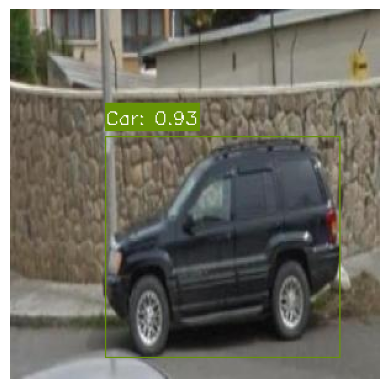

Processing d674c99dc4e7d7d4_jpg.rf.d95251aa358a026794e467f8826ac3fd.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/d674c99dc4e7d7d4_jpg.rf.d95251aa358a026794e467f8826ac3fd.jpg: 640x640 1 Person face, 37.2ms
Speed: 2.6ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


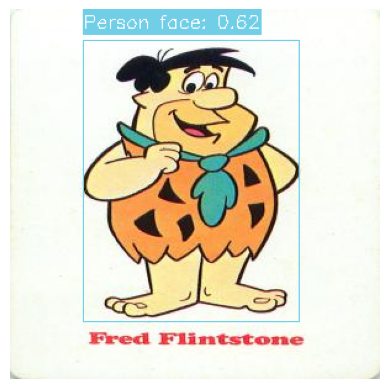

Processing images-w98_jpeg_jpg.rf.4585ab2f21d118a6cc5fc89d8e158274.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/images-w98_jpeg_jpg.rf.4585ab2f21d118a6cc5fc89d8e158274.jpg: 640x640 3 Elevators, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


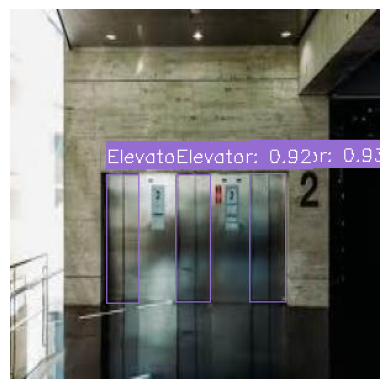

Processing 189_jpg.rf.933d3ac6a7352b1899c1d7e4b26de7d4.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/189_jpg.rf.933d3ac6a7352b1899c1d7e4b26de7d4.jpg: 640x640 1 Crosswalk, 1 person, 37.1ms
Speed: 4.2ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


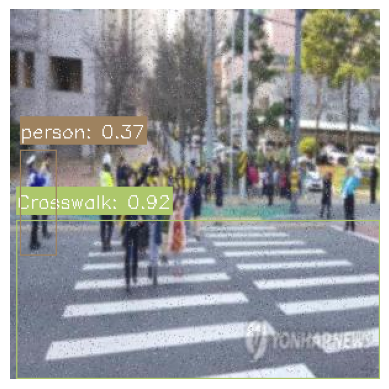

Processing traffic-light-158-_jpg.rf.02b18bf76f144990a4300f1e4f28e013.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/traffic-light-158-_jpg.rf.02b18bf76f144990a4300f1e4f28e013.jpg: 640x640 1 Yellow light, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


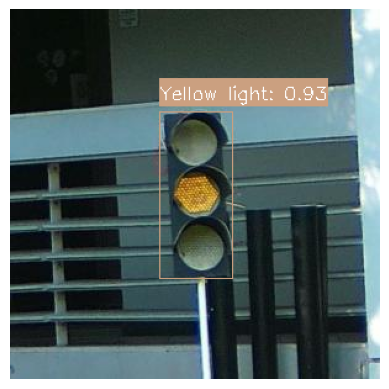

Processing gettyimages-1249981186-2048x2048_jpg.rf.2f9a8134611d9400f15f69b098ff7d93.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/gettyimages-1249981186-2048x2048_jpg.rf.2f9a8134611d9400f15f69b098ff7d93.jpg: 640x640 6 Rats, 37.1ms
Speed: 2.6ms preprocess, 37.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


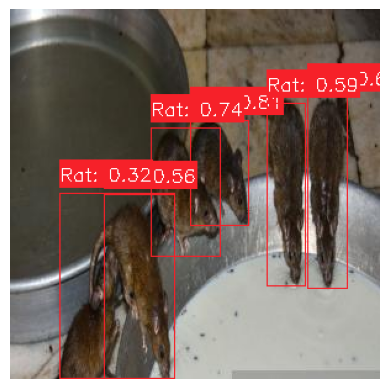

Processing 91_jpg.rf.04f9fcc823e15cb19849781a1b1a7453.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/91_jpg.rf.04f9fcc823e15cb19849781a1b1a7453.jpg: 640x640 1 Tree, 37.1ms
Speed: 2.4ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


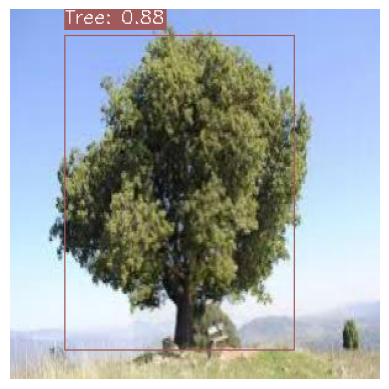

Processing room-g1d8650015_1280_jpg.rf.cc778375f8cc87c6d08aed6c893584f4.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/room-g1d8650015_1280_jpg.rf.cc778375f8cc87c6d08aed6c893584f4.jpg: 640x640 1 Door, 37.2ms
Speed: 2.6ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


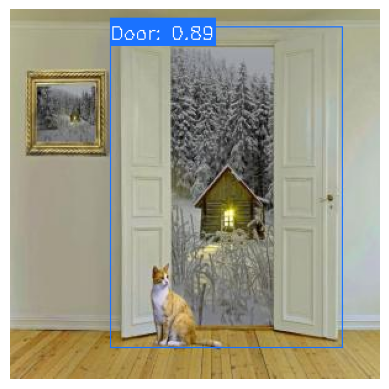

Processing COCO_train2014_000000042819_jpg.rf.ede67968fe6262833c250b786d381e04.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/COCO_train2014_000000042819_jpg.rf.ede67968fe6262833c250b786d381e04.jpg: 640x640 2 Person faces, 1 Train, 37.1ms
Speed: 2.6ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


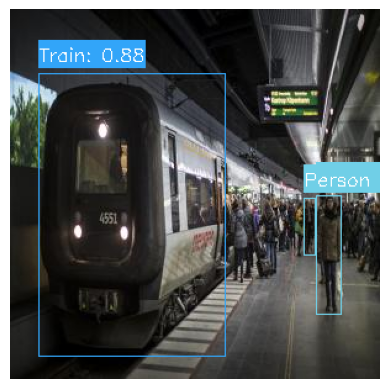

Processing 103_jpg.rf.6f79dbf47999bf06e7aff7f4b77e698b.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/103_jpg.rf.6f79dbf47999bf06e7aff7f4b77e698b.jpg: 640x640 1 Crosswalk, 37.1ms
Speed: 2.4ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


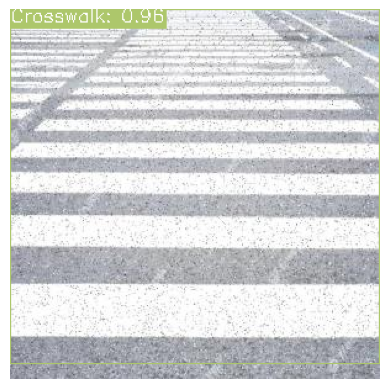

Processing Image_013422_jpg.rf.c4967791502b4e3badb6990fa68d4fd1.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/Image_013422_jpg.rf.c4967791502b4e3badb6990fa68d4fd1.jpg: 640x640 1 Truck, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


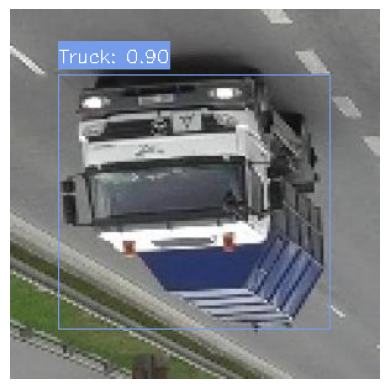

Processing Screenshot-2023-04-10-123807_png.rf.1d33ebfd1dc135276c2fb83808d8e995.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/Screenshot-2023-04-10-123807_png.rf.1d33ebfd1dc135276c2fb83808d8e995.jpg: 640x640 2 bicycles, 37.2ms
Speed: 2.5ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


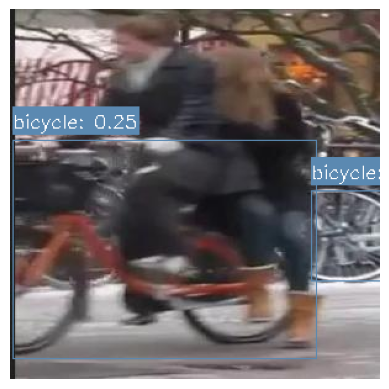

Processing 2000-mitsubishi-fuso-fe639-diesel-bo_jpg.rf.e85d807daddf5060265bd7364ae63a8d.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/2000-mitsubishi-fuso-fe639-diesel-bo_jpg.rf.e85d807daddf5060265bd7364ae63a8d.jpg: 640x640 1 Bus, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


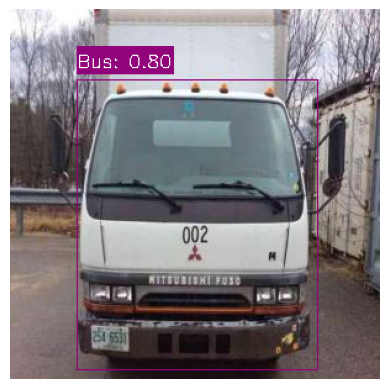

Processing images59_jpg.rf.66b17b7827606aaffcd2dc5030335c71.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/images59_jpg.rf.66b17b7827606aaffcd2dc5030335c71.jpg: 640x640 1 Green Light, 1 pothole, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


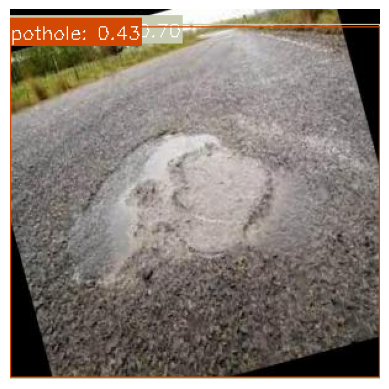

Processing e6740414-image_53_jpeg_jpg.rf.9828fdbf729001c5b98b955e14050ae7.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/e6740414-image_53_jpeg_jpg.rf.9828fdbf729001c5b98b955e14050ae7.jpg: 640x640 1 Door, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


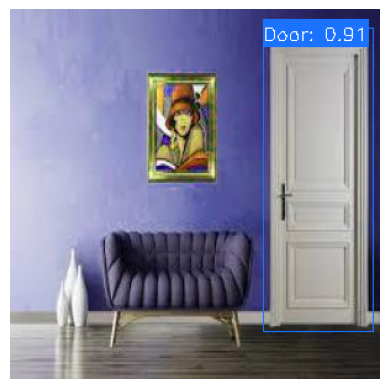

Processing 140_jpg.rf.2f77cd7d40e49fe54e4facb2ab00b4e7.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/140_jpg.rf.2f77cd7d40e49fe54e4facb2ab00b4e7.jpg: 640x640 1 Train, 37.2ms
Speed: 2.4ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


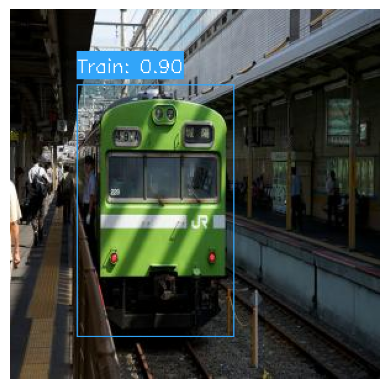

Processing 000000035936_jpg.rf.8ce9eed8645c50bbe3706258fd5287db.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/000000035936_jpg.rf.8ce9eed8645c50bbe3706258fd5287db.jpg: 640x640 1 Train, 37.3ms
Speed: 3.9ms preprocess, 37.3ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


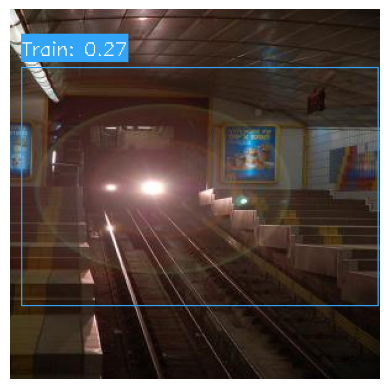

Processing 664_jpeg_jpg.rf.ff6fa423737d49c922d8f991343301a0.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/664_jpeg_jpg.rf.ff6fa423737d49c922d8f991343301a0.jpg: 640x640 1 Tree, 37.2ms
Speed: 2.6ms preprocess, 37.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


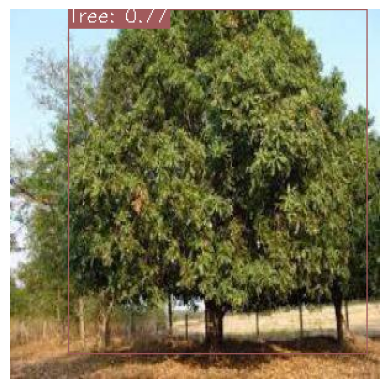

Processing apart-33-_jpg.rf.b89e6ef255c1f7921b746ce74a50bfba.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/apart-33-_jpg.rf.b89e6ef255c1f7921b746ce74a50bfba.jpg: 640x640 1 Door, 2 Elevators, 37.1ms
Speed: 3.3ms preprocess, 37.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


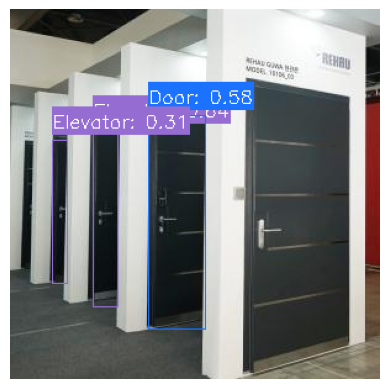

Processing 399831857-1600751327_jpeg_jpg.rf.6c9c2eef46695ae335f43e31e37bfd88.jpg

image 1/1 /kaggle/input/object-detection-of-26-objects/dataset_26/test/images/399831857-1600751327_jpeg_jpg.rf.6c9c2eef46695ae335f43e31e37bfd88.jpg: 640x640 4 Person faces, 37.2ms
Speed: 2.7ms preprocess, 37.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


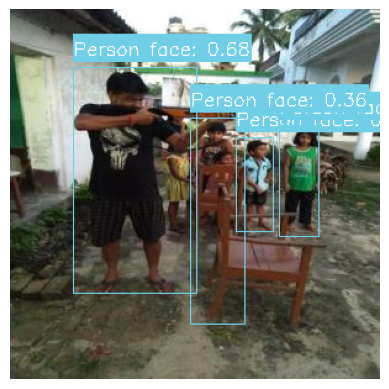

In [10]:

# Generate colors for each class
class_colors = generate_class_colors(model)

# Example usage with the path to the test directory and a limit of 20 images
process_test_images('/kaggle/input/object-detection-of-26-objects/dataset_26/test/images', class_colors, limit=20)  # Replace with your test directory path
